# Installation and importing

In [1]:
%%capture
!pip install tika
!pip install matplotlib
!pip install langchain
!pip install -qU llama-index-llms-openai
!pip install langchain_community
!pip install langchain_core
!pip install langchain_openai
!pip install langchain_experimental
!pip install faiss-cpu
!pip install datasets
!pip install ragas

In [2]:
import os
import re
import getpass
import pandas as pd
from tika import parser
from datasets import load_dataset, Dataset
from ragas import evaluate
import matplotlib.pyplot as plt
from ragas.metrics import (answer_relevancy, faithfulness, context_recall, context_precision)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_experimental.text_splitter import SemanticChunker

In [3]:
os.environ["OPENAI_API_KEY"]= "sk-proj-EpcuRNoHC6vZvieDWSR2T3BlbkFJVgs9EQBu6tx0CO9VchbF"

## Introduction

Our project aims to create a Question Answering (QA) model that delves into the foundation of human rights, exploring seminal legal documents like Justinian's Code and Magna Carta. To achieve this, we're developing a RAG (Retrieval-Augmented Generation) model that leverages the capabilities of Large Language Models (LLMs). Our RAG model will retrieve relevant passages from these historical texts and generate accurate answers to users' questions, providing insights into the evolution of human rights and their significance in modern times.

Our project will:


*   Develop a RAG model that focuses on legal-human rights documents
*   Train the model on a dataset comprising Justinian's Code, Magna Carta, and other relevant texts
*   Evaluate the model's performance on a test set of questions
*   Fine-tune the model for improved accuracy and relevance

Our RAG model builds upon the advancements in LLMs, which have demonstrated exceptional language understanding and generation capabilities. By integrating retrieval capabilities into our RAG model, we can ensure that the generated answers are grounded in the original texts, providing a more reliable and informative QA experience.

## Universal Declaration of the Human Rights

In [125]:
text_file = parser.from_file("datasets/Universal Declaration of the Human Rights.pdf")
print(text_file['content'].replace('\n', '')[:100])

Universal Declaration of Human Rights Preamble Whereas recognition of the inherent dignity and of th


### Chunking methods

Chunking is a crucial step in preprocessing text data for our RAG model. We explore three approaches: naive chunking, semantic chunking and manual chunking.

**Recursive Character Text Splitter** (also called naive chunking) - it is a fundamental tool in the LangChain suite for breaking down large texts into manageable, semantically coherent chunks. This method is particularly recommended for initial text processing due to its ability to maintain the contextual integrity of the text. It operates by recursively splitting text based on a list of user-defined characters, ensuring that related pieces of text remain adjacent to each other, thus preserving their semantic relationship.

In [42]:
naive_chunker = RecursiveCharacterTextSplitter(
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

naive_chunks = naive_chunker.split_text(text_file['content'])
naive_chunks_df = pd.DataFrame(naive_chunks)
naive_chunks_df.head()

,0
0,Universal Declaration of Human Rights \n\nPrea...
1,"and peace in the world, \n\nWhereas disregard..."
2,in which human beings shall enjoy freedom of s...
3,"resort, to rebellion against tyranny and oppre..."
4,Whereas the peoples of the United Nations have...


**Semantic Chunking** - it considers the relationships within the text. It divides the text into meaningful, semantically complete chunks. This approach ensures the information’s integrity during retrieval, leading to a more accurate and contextually appropriate outcome. It is slower compared to the previous chunking strategy.

**Interquartile chunking** - in this method, the interquartile distance is used to split chunks.

In [43]:
interquartile_chunker = SemanticChunker(
    OpenAIEmbeddings(), breakpoint_threshold_type="interquartile"
)

interquartile_chunks = interquartile_chunker.create_documents([text_file['content']])
interquartile_chunks_df = pd.DataFrame(interquartile_chunks)
interquartile_chunks_df.head()

,0,1,2
0,"(page_content, \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...","(metadata, {})","(type, Document)"
1,"(page_content, This right may not be invoked i...","(metadata, {})","(type, Document)"
2,"(page_content, Everyone has the right to own p...","(metadata, {})","(type, Document)"
3,"(page_content, No one shall be arbitrarily dep...","(metadata, {})","(type, Document)"
4,"(page_content, Parents have a prior right to c...","(metadata, {})","(type, Document)"


**Percentile chunking** - in this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split.

In [44]:
percentile_chunker = SemanticChunker(
    OpenAIEmbeddings(), breakpoint_threshold_type="percentile"
)

percentile_chunks = percentile_chunker.create_documents([text_file['content']])
percentile_chunks_df = pd.DataFrame(percentile_chunks)
percentile_chunks_df.head()

,0,1,2
0,"(page_content, \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...","(metadata, {})","(type, Document)"
1,"(page_content, This right may not be invoked i...","(metadata, {})","(type, Document)"
2,"(page_content, Everyone has the right to own p...","(metadata, {})","(type, Document)"
3,"(page_content, No one shall be arbitrarily dep...","(metadata, {})","(type, Document)"
4,"(page_content, Parents have a prior right to c...","(metadata, {})","(type, Document)"


**Manual chunking** - this chunking method was manually created by us in order to capture all of the articles in the document in different chunks. It uses basic regular expressions.

In [65]:
manual_chunks = re.split(r'Article \d+\s*|Preamble', text_file['content'])[1:]  # Split on "ART. X " and keep the chunks
manual_chunks_df = pd.DataFrame(manual_chunks)
manual_chunks_df.head()

,0
0,\n\nWhereas recognition of the inherent digni...
1,All human beings are born free and equal in di...
2,Everyone is entitled to all the rights and fre...
3,"Everyone has the right to life, liberty and th..."
4,No one shall be held in slavery or servitude; ...


### Model definition

In this part, we will define our RAG model. Firstly, we will define the template for our model. By template, we mean:

*   If the model can't find a related context to our question in the text, it will output "I don't know"
*   Otherwise, it will take the related context and augment it with the user defined question



In [66]:
rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

RAG models retrieve the context from vector databases. In this part, we will define 4 vector databases for each of our chunks. And to transfer our text file into numbers in the vector databases, we will use the "text-embedding-3-large" embedding model from OpenAI.

In [67]:
naive_vectorstore = FAISS.from_texts(naive_chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large"))
naive_retriever = naive_vectorstore.as_retriever(search_kwargs={"k" : 4})

In [68]:
interquartile_vectorstore = FAISS.from_documents(interquartile_chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large"))
interquartile_retriever = interquartile_vectorstore.as_retriever(search_kwargs={"k" : 4})

In [69]:
percentile_vectorstore = FAISS.from_documents(percentile_chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large"))
percentile_retriever = percentile_vectorstore.as_retriever(search_kwargs={"k" : 4})

In [70]:
manual_vectorstore = FAISS.from_texts(manual_chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large"))
manual_retriever = manual_vectorstore.as_retriever(search_kwargs={"k" : 4})

Our base model for question answering system will be ChatOpenAI.

In [71]:
base_model = ChatOpenAI()

These are the main bodies of ouor models. We will first define the context by setting it to relevant retriever from our vectorbase and in the same way, we will define the question by setting it to the user defined question. Then these two will go through our pre-defined prompt. As we know from earlier, the prompt will retrieve the context and augment it with the question before feeding them to our base model. When the base model receives these two, it will generate an answer. The answer will solely be related to our database.

In [72]:
naive_rag_chain = (
    {"context" : naive_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | base_model
    | StrOutputParser()
)

In [73]:
interquartile_rag_chain = (
    {"context" : interquartile_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | base_model
    | StrOutputParser()
)

In [74]:
percentile_rag_chain = (
    {"context" : percentile_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | base_model
    | StrOutputParser()
)

In [75]:
manual_rag_chain = (
    {"context" : manual_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | base_model
    | StrOutputParser()
)

### Testing with random questions

For comparing the different chunking methods and in general, for comparing the models, we will create some random questions based on our text and get answers from these models. We will also create some questions that are not in the document to see if it outputs "I don't know".

In [76]:
# Test 1
question = "What is the natural and fundamental group in society?"

naive_answer_1 = naive_rag_chain.invoke(question)
interquartile_answer_1 = interquartile_rag_chain.invoke(question)
percentile_answer_1 = percentile_rag_chain.invoke(question)
manual_answer_1 = manual_rag_chain.invoke(question)

print(f"The question is: {question}")
print(f"\nThe answer of naive chunking is: {naive_answer_1}")
print(f"\nThe answer of interquartile chunking is: {interquartile_answer_1}")
print(f"\nThe answer of percentile chunking is: {percentile_answer_1}")
print(f"\nThe answer of manual chunking is: {manual_answer_1}")

The question is: What is the natural and fundamental group in society?

The answer of naive chunking is: The natural and fundamental group in society is the family.

The answer of interquartile chunking is: The natural and fundamental group in society is the family, according to the context provided.

The answer of percentile chunking is: The natural and fundamental group in society is the family, according to the context provided.

The answer of manual chunking is: The natural and fundamental group in society is considered to be the family, according to the context provided.


In [78]:
# Test 2
question = "Who has the right to freedom of thought?"

naive_answer_2 = naive_rag_chain.invoke(question)
interquartile_answer_2 = interquartile_rag_chain.invoke(question)
percentile_answer_2 = percentile_rag_chain.invoke(question)
manual_answer_2 = manual_rag_chain.invoke(question)

print(f"The question is: {question}")
print(f"\nThe answer of naive chunking is: {naive_answer_2}")
print(f"\nThe answer of interquartile chunking is: {interquartile_answer_2}")
print(f"\nThe answer of percentile chunking is: {percentile_answer_2}")
print(f"\nThe answer of manual chunking is: {manual_answer_2}")

The question is: Who has the right to freedom of thought?

The answer of naive chunking is: Everyone has the right to freedom of thought according to the context provided.

The answer of interquartile chunking is: Everyone has the right to freedom of thought.

The answer of percentile chunking is: Everyone has the right to freedom of thought, conscience, and religion, as stated in the provided document.

The answer of manual chunking is: Everyone has the right to freedom of thought, as stated in the context provided.


### Model Evaluation

In the final part, we will ask the OpenAI model to generate questions (to behave like a teacher preparing questions for the students) from the document in order to assess our model's ability to answer questions.

In order to achieve this, we'll first create synthetic documents from our original data by chunking them "naively". Next, we'll create our question prompt for the OpenAI model, which will take this prompt and generate questions based on the synthetic documents (it will behave like a teacher trying to prepare questions for an exam). Then in order to be able to compare the generated answers with the real answers, we'll create also a ground truth prompt for the OpenAI model. This ground truth will always give the right answers because we extract the context from which the question was generated from and feed it to the ground truth prompt.

In [79]:
synthetic_data_splitter = RecursiveCharacterTextSplitter(
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

synthetic_data_chunks = synthetic_data_splitter.create_documents([text_file['content']])

In [80]:
questions = []
ground_truths_semantic = []
contexts = []
answers = []

We'll start with percentile chunking.

In [81]:
question_prompt = """\
You are a teacher preparing a test. Please create a question that can be answered by referencing the following context.

Context:
{context}
"""

ground_truth_prompt = """\
Use the following context and question to answer this question using *only* the provided context.

Question:
{question}

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_prompt)
ground_truth_prompt = ChatPromptTemplate.from_template(ground_truth_prompt)

question_chain = question_prompt | ChatOpenAI(model="gpt-3.5-turbo") | StrOutputParser()
ground_truth_chain = ground_truth_prompt | ChatOpenAI(model="gpt-4-turbo-preview") | StrOutputParser()

for chunk in synthetic_data_chunks[10:20]:
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]}))
  answers.append(percentile_rag_chain.invoke(questions[-1]))

In [82]:
qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
  qagc_list.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset = Dataset.from_list(qagc_list)

In [83]:
result = evaluate(eval_dataset, metrics=[context_precision,
                                         faithfulness,
                                         answer_relevancy,
                                         context_recall]);

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [84]:
result_df = result.to_pandas()
result_df

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall
0,"Question: According to the context provided, w...",The principle emphasized in Article 2 of the D...,[spirit of brotherhood. \n\nArticle 2 \n\nEv...,The principle emphasized in Article 2 of the D...,0.0,0.5,0.957460,0.0
1,"Question: According to the provided context, w...","Answer: Factors such as race, nationality, rel...","[political or other opinion, national or socia...","According to the provided context, factors tha...",1.0,1.0,0.954312,1.0
2,"Question: According to the context provided, w...","According to the context provided, the specifi...","[belongs, whether it be independent, trust, no...","According to the context provided, under Artic...",1.0,1.0,0.975967,1.0
3,"Question: According to the context provided, w...",I don't know.,[No one shall be held in slavery or servitude;...,"According to the context provided, under Artic...",1.0,1.0,0.000000,1.0
4,"Question: According to the context provided, w...","According to the context provided, individuals...",[Everyone has the right to recognition everywh...,"According to the context provided, individuals...",1.0,1.0,0.916578,1.0
5,Question: According to Article 8 of the Declar...,Answer: Everyone has the right to equal protec...,[discrimination in violation of this Declarati...,"According to Article 8 of the Declaration, eve...",1.0,0.5,0.898954,1.0
6,Question: How does the constitution protect in...,The constitution protects individuals from arb...,[for acts violating the fundamental rights gra...,The constitution protects individuals from arb...,1.0,1.0,0.862841,1.0
7,"Question: According to the context provided, w...","According to the context provided, Article 11 ...",[Everyone is entitled in full equality to a fa...,"According to the context provided, Article 11 ...",1.0,1.0,0.906340,1.0
8,"Question:\nAccording to the context provided, ...",Everyone charged with a penal offence has the ...,[1. Everyone charged with a penal offence has ...,"According to the context provided, everyone ch...",1.0,1.0,0.928532,1.0
9,"Question:\nAccording to the context provided, ...",The principle being described in relation to c...,[2. No one shall be held guilty of any penal o...,The principle being described in relation to c...,1.0,1.0,0.970546,1.0


In [86]:
for metric, score in result.items():
    print(f"Metric: {metric}, score: {score}", end='\n')

Metric: context_precision, score: 0.89999999991
Metric: faithfulness, score: 0.9
Metric: answer_relevancy, score: 0.8371529146590362
Metric: context_recall, score: 0.9


In [111]:
for _, row in result_df.query('faithfulness < 1').iterrows():
    print(row.question, end='\n')
    print("Answer: ", row.answer, end='\n')
    print("Ground truth: ", row.ground_truth, end='\n')
    print("Faithfulness: ", row.faithfulness, end='\n')
    print('---------------------')

Question: According to the context provided, what principle is emphasized in Article 2 of the Declaration being referenced?
Answer:  The principle emphasized in Article 2 of the Declaration is non-discrimination and equality, stating that everyone is entitled to all the rights and freedoms without any distinction based on various factors.
Ground truth:  The principle emphasized in Article 2 of the Declaration being referenced is the principle of non-discrimination.
Faithfulness:  0.5
---------------------
Question: According to Article 8 of the Declaration, what right does everyone have in regards to discrimination and incitement to discrimination?
Answer:  Answer: Everyone has the right to equal protection against any discrimination and incitement to such discrimination according to Article 8 of the Declaration.
Ground truth:  According to Article 8 of the Declaration, everyone has the right to an effective remedy by the competent national tribunals for acts of discrimination in viola

Let's do the same things for manual chunking.

In [87]:
answers_manual = []

for question in questions:
  answers_manual.append(manual_rag_chain.invoke(question))

In [88]:
qagc_manual = []

for question, answer, context, ground_truth in zip(questions, answers_manual, contexts, ground_truths_semantic):
  qagc_manual.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset_manual = Dataset.from_list(qagc_manual)

In [89]:
result_manual = evaluate(eval_dataset_manual, metrics=[context_precision,
                                         faithfulness,
                                         answer_relevancy,
                                         context_recall])

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [93]:
result_manual_df = result_manual.to_pandas()
result_manual_df

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall
0,"Question: According to the context provided, w...",The principle of non-discrimination is emphasi...,[spirit of brotherhood. \n\nArticle 2 \n\nEv...,The principle emphasized in Article 2 of the D...,0.0,1.000000,0.871105,0.0
1,"Question: According to the provided context, w...","According to the provided context, factors suc...","[political or other opinion, national or socia...","According to the provided context, factors tha...",1.0,0.700000,0.971180,1.0
2,"Question: According to the context provided, w...",The specific rights guaranteed to everyone und...,"[belongs, whether it be independent, trust, no...","According to the context provided, under Artic...",1.0,1.000000,0.975967,1.0
3,"Question: According to the context provided, w...",I don't know.,[No one shall be held in slavery or servitude;...,"According to the context provided, under Artic...",1.0,1.000000,0.000000,1.0
4,"Question: According to the context provided, w...",Answer: The fundamental right that individuals...,[Everyone has the right to recognition everywh...,"According to the context provided, individuals...",1.0,1.000000,0.967665,1.0
5,Question: According to Article 8 of the Declar...,Answer: According to Article 8 of the Declarat...,[discrimination in violation of this Declarati...,"According to Article 8 of the Declaration, eve...",1.0,1.000000,0.901003,1.0
6,Question: How does the constitution protect in...,The constitution protects individuals from arb...,[for acts violating the fundamental rights gra...,The constitution protects individuals from arb...,1.0,0.333333,0.964884,1.0
7,"Question: According to the context provided, w...","According to the context provided, Article 11 ...",[Everyone is entitled in full equality to a fa...,"According to the context provided, Article 11 ...",1.0,1.000000,0.943339,1.0
8,"Question:\nAccording to the context provided, ...","According to the context provided, everyone ch...",[1. Everyone charged with a penal offence has ...,"According to the context provided, everyone ch...",1.0,1.000000,0.943714,1.0
9,"Question:\nAccording to the context provided, ...",The principle being described in relation to c...,[2. No one shall be held guilty of any penal o...,The principle being described in relation to c...,1.0,0.666667,0.967770,1.0


In [94]:
for metric, score in result_manual.items():
    print(f"Metric: {metric}, score: {score}", end='\n')

Metric: context_precision, score: 0.89999999991
Metric: faithfulness, score: 0.8699999999999999
Metric: answer_relevancy, score: 0.8506626506289852
Metric: context_recall, score: 0.9


In [95]:
result_manual_df.query('faithfulness < 1')

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall
1,"Question: According to the provided context, w...","According to the provided context, factors suc...","[political or other opinion, national or socia...","According to the provided context, factors tha...",1.0,0.700000,0.971180,1.0
6,Question: How does the constitution protect in...,The constitution protects individuals from arb...,[for acts violating the fundamental rights gra...,The constitution protects individuals from arb...,1.0,0.333333,0.964884,1.0
9,"Question:\nAccording to the context provided, ...",The principle being described in relation to c...,[2. No one shall be held guilty of any penal o...,The principle being described in relation to c...,1.0,0.666667,0.967770,1.0


In [96]:
for _, row in result_manual_df.query('faithfulness < 1').iterrows():
    print(row.question, end='\n')
    print("Answer: ", row.answer, end='\n')
    print("Ground truth: ", row.ground_truth, end='\n')
    print("Faithfulness: ", row.faithfulness, end='\n')
    print('---------------------')

Question: According to the provided context, what factors should not be used to discriminate against individuals?
Answer:  According to the provided context, factors such as race, color, sex, language, religion, political or other opinion, national or social origin, property, birth, or other status should not be used to discriminate against individuals.
Ground truth:  According to the provided context, factors that should not be used to discriminate against individuals include political or other opinion, national or social origin, property, birth, or other status. Additionally, no distinction shall be made based on the political, jurisdictional, or international status of the country or territory to which a person belongs.
Faithfulness:  0.7
---------------------
Question: How does the constitution protect individuals from arbitrary actions such as arrest, detention, or exile?
Answer:  The constitution protects individuals from arbitrary actions such as arrest, detention, or exile by s

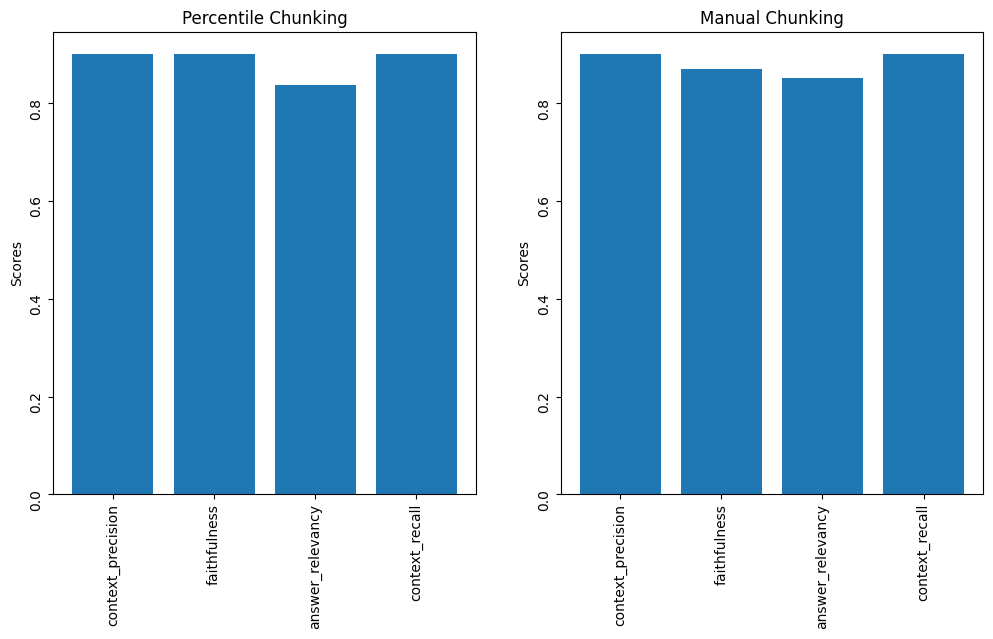

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(list(result.keys()), list(result.values()))
axes[1].bar(list(result_manual.keys()), list(result_manual.values()))
axes[0].tick_params(labelrotation=90)
axes[1].tick_params(labelrotation=90)
axes[0].set_title("Percentile Chunking")
axes[1].set_title("Manual Chunking")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("Scores")
plt.show()

Let's now compare all of the chunking methods in order to choose the best among them for our next dataset.

In [113]:
answers_quartile = []

for question in questions:
  answers_quartile.append(interquartile_rag_chain.invoke(question))

In [114]:
qagc_quartile = []

for question, answer, context, ground_truth in zip(questions, answers_quartile, contexts, ground_truths_semantic):
  qagc_quartile.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset_quartile = Dataset.from_list(qagc_quartile)

In [115]:
result_quartile = evaluate(eval_dataset_quartile, metrics=[context_precision,
                                         faithfulness,
                                         answer_relevancy,
                                         context_recall])

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [116]:
answers_naive = []

for question in questions:
  answers_naive.append(naive_rag_chain.invoke(question))

In [117]:
qagc_naive = []

for question, answer, context, ground_truth in zip(questions, answers_naive, contexts, ground_truths_semantic):
  qagc_naive.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset_naive = Dataset.from_list(qagc_naive)

In [118]:
result_naive = evaluate(eval_dataset_naive, metrics=[context_precision,
                                         faithfulness,
                                         answer_relevancy,
                                         context_recall])

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [119]:
for metric, score in result_quartile.items():
    print(f"Metric: {metric}, score: {score}", end='\n')

Metric: context_precision, score: 0.89999999991
Metric: faithfulness, score: 0.8557142857142856
Metric: answer_relevancy, score: 0.9263559279295326
Metric: context_recall, score: 0.9


In [120]:
for metric, score in result_naive.items():
    print(f"Metric: {metric}, score: {score}", end='\n')

Metric: context_precision, score: 0.89999999991
Metric: faithfulness, score: 0.9400000000000001
Metric: answer_relevancy, score: 0.8506374851518224
Metric: context_recall, score: 0.9


Seems like naive chunking performs the best. Let's choose it for further analysing other datasets.

## Magna Carta

The text was preprocessed; the header and page numbers were removed.

In [126]:
magna_carta = parser.from_file("datasets/Magna Carta.pdf")
print(magna_carta['content'].replace('\n', '')[:100])

Preamble: John, by the grace of God, king of England, lord of Ireland, duke of Normandy and Aquitain


### Chunking

In the first part, we saw that naive chunking results in a better performance compared to others (though the differences are too small).

In [127]:
naive_chunker = RecursiveCharacterTextSplitter(
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

naive_chunks = naive_chunker.split_text(magna_carta['content'])
naive_chunks_df = pd.DataFrame(naive_chunks)
naive_chunks_df.head()

,0
0,Preamble:
1,"John, by the grace of God, king of England, lo..."
2,"stewards, servants, and to all his bailiffs an..."
3,God and the advancement of his holy Church and...
4,"England and cardinal of the holy Roman Church,..."


### Model Definition

We will apply the same model defined in the first part.

In [130]:
rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

In [131]:
naive_vectorstore = FAISS.from_texts(naive_chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large"))
naive_retriever = naive_vectorstore.as_retriever(search_kwargs={"k" : 4})

In [132]:
base_model = ChatOpenAI()

In [133]:
naive_rag_chain = (
    {"context" : naive_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | base_model
    | StrOutputParser()
)

### Testing with random questions

In [135]:
# Test 1
question = "Where should common pleas be held?"

naive_answer_1 = naive_rag_chain.invoke(question)

print(f"The question is: {question}")
print(f"\nThe answer of naive chunking is: {naive_answer_1}")

The question is: Where should common pleas be held?

The answer of naive chunking is: Common pleas should be held in some fixed place, not following the court.


In [137]:
# Test 2
question = "When are the foreign born knights banished?"

naive_answer_2 = naive_rag_chain.invoke(question)

print(f"The question is: {question}")
print(f"\nThe answer of naive chunking is: {naive_answer_2}")

The question is: When are the foreign born knights banished?

The answer of naive chunking is: When peace is restored, the foreign born knights are banished from the kingdom.


Our model answers correctly all the questions. Let's evaluate it on sets of questions generated by OpenAI.

### Model evaluation

In [155]:
synthetic_data_splitter = RecursiveCharacterTextSplitter(
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

synthetic_data_chunks = synthetic_data_splitter.create_documents([magna_carta['content']])

In [156]:
questions = []
ground_truths_semantic = []
contexts = []
answers = []

In [157]:
question_prompt = """\
You are a teacher preparing a test. Please create a question that can be answered by referencing the following context.

Context:
{context}
"""

ground_truth_prompt = """\
Use the following context and question to answer this question using *only* the provided context.

Question:
{question}

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_prompt)
ground_truth_prompt = ChatPromptTemplate.from_template(ground_truth_prompt)

question_chain = question_prompt | ChatOpenAI(model="gpt-3.5-turbo") | StrOutputParser()
ground_truth_chain = ground_truth_prompt | ChatOpenAI(model="gpt-4-turbo-preview") | StrOutputParser()

for chunk in synthetic_data_chunks[:15]:
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]}))
  answers.append(percentile_rag_chain.invoke(questions[-1]))

In [158]:
qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
  qagc_list.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset = Dataset.from_list(qagc_list)

In [159]:
result = evaluate(eval_dataset, metrics=[context_precision,
                                         faithfulness,
                                         answer_relevancy,
                                         context_recall]);

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.


In [160]:
result_df = result.to_pandas()
result_df

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall
0,The Preamble to the United States Constitution...,I don't know.,[Preamble:],According to the Preamble to the United States...,1.0,0.000000,0.000000,1.0
1,"Question: According to the context provided, w...",I don't know.,"[John, by the grace of God, king of England, l...","Based on the provided context, the author of t...",1.0,0.000000,0.000000,1.0
2,Question: To whom is the letter addressing in ...,The letter is addressing the General Assembly.,"[stewards, servants, and to all his bailiffs a...","The letter is addressing stewards, servants, b...",1.0,0.000000,0.944142,1.0
3,What is the primary purpose of the actions bei...,The primary purpose of the actions being descr...,[God and the advancement of his holy Church an...,The primary purpose of the actions being descr...,1.0,0.000000,1.000000,1.0
4,Question: Who were some of the prominent churc...,I don't know.,[England and cardinal of the holy Roman Church...,Some of the prominent church figures in Englan...,1.0,0.000000,0.000000,1.0
5,Question: Who are some of the notable individu...,I don't know.,"[of Coventry, Benedict of Rochester, bishops; ...",The notable individuals mentioned in the conte...,1.0,0.000000,0.000000,1.0
6,Question: Who were some of the illustrious men...,I don't know.,"[and of the illustrious men William Marshal, e...",The illustrious men mentioned in the context p...,1.0,1.000000,0.000000,1.0
7,Question:\nWho were some of the liegemen menti...,I don't know.,"[Peter Fitz Herbert, Hubert De Burgh (senescha...",Some of the liegemen mentioned in the context ...,1.0,1.000000,0.000000,1.0
8,Question: What did the Magna Carta grant to th...,I don't know.,"[1. In the first place we have granted to God,...",The Magna Carta granted the English Church fre...,1.0,1.000000,0.000000,1.0
9,"In the context provided, what specific aspect ...",The specific aspect of the English Church high...,[liberties inviolate; and we will that it be t...,The specific aspect of the English Church high...,1.0,0.333333,0.989799,1.0


In [161]:
for metric, score in result.items():
    print(f"Metric: {metric}, score: {score}", end='\n')

Metric: context_precision, score: 0.9999999999
Metric: faithfulness, score: 0.25641025641025644
Metric: answer_relevancy, score: 0.3213360102965338
Metric: context_recall, score: 1.0


In [162]:
for _, row in result_df.query('faithfulness < 1').iterrows():
    print(row.question, end='\n')
    print("Answer: ", row.answer, end='\n')
    print("Ground truth: ", row.ground_truth, end='\n')
    print("Faithfulness: ", row.faithfulness, end='\n')
    print('---------------------')

The Preamble to the United States Constitution begins with the famous words, "We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defence, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America."

Question:
According to the Preamble to the United States Constitution, what are the six purposes for which the Constitution was established?
Answer:  I don't know.
Ground truth:  According to the Preamble to the United States Constitution, the six purposes for which the Constitution was established are:

1. To form a more perfect Union
2. Establish Justice
3. Insure domestic Tranquility
4. Provide for the common defence
5. Promote the general Welfare
6. Secure the Blessings of Liberty to ourselves and our Posterity
Faithfulness:  0.0
---------------------
Question: According to the con

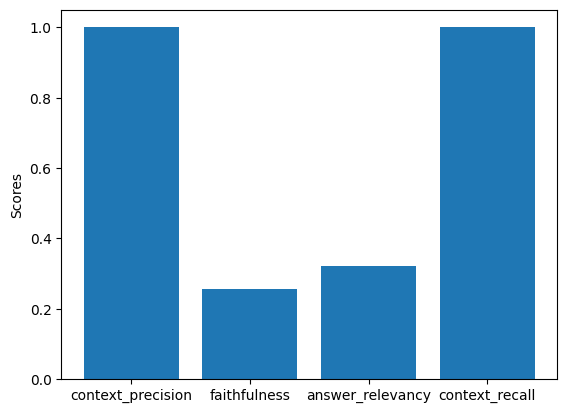

In [163]:
plt.bar(list(result.keys()), list(result.values()))
plt.ylabel("Scores")
plt.show()